<a href="https://colab.research.google.com/github/sushma-ikim-nrw/sushma/blob/main/week_07_generative_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chapter 3 - Computer Vision

**This week's exercise has 4 tasks, for a total of 10 points. Don't forget to submit your solutions to GitHub!**

In this chapter, we want you to become proficient at the following tasks:
- Building a modern PyTorch segmentation model
- Training a modern model on a real-world segmentation task and achieving passable results

**Note**: This is the last exercise concerning pure computer vision. Starting next week, we will begin with Natural Language Processing, i.e. text data. Therefore, don't worry too much if this exercise feels hard or if you can't complete all of it ;)

#### Chapter 3.5 - Segmentation

In previous tasks, we solved classification problems - we provide some input(s), typically an image, and get out a few numbers, which are the predicted pseudo-probabilities that our input belongs to some class, such as "tumor" or "no tumor". For this exercise, we will explore a new task that is extremely common in medical AI research and in clinical practice. This task is called segmentation. In segmentation, the goal is to go from an input image to one or several segmentations (also called *segmentation maps*) of that image. For the example of LiTS, this means that our input remains the same - a 256x256 image with 1 channel. However, our model outputs and targets are now different - they also have the shape 256x256 pixels, times the number of output classes, in our case 3 (background, liver, liver+tumor). Each 256x256 output is basically a map of which pixels in the original image belong to a certain class with what (pseudo-)probability. The training objective, in its simplest form, is also the same; Cross-Entropy Loss, but per pixel, instead of per-image.

To solve today's tasks, we will need to build ourselves a few new things that look almost the same as things we have already built.

**Task 1 (2 points)**: We will need a new Dataset class. It is the same as usual, except this time, when we return image and target in the getitem method, our target is now also a multi-dimensional tensor of size.

We will return two kinds of targets - class-index targets and one-hot encoded targets. Class-index targets you already know. Every pixel is assigned a class, which can be 0 for background, 1 for liver, and 2 for lesions. The corresponding tensor has the size $H * W$. One-hot encoded targets instead have size $C * H * W$ - each channel is one class (the 0th channel is background, etc.), and the values for each pixel in a channel are 1 if that pixel belongs to that class and 0 if not. We will need both later on - class-index targets because that is the input for the normal CrossEntropyLoss, and one-hot targets because we will use them in this format for our DiceLoss.

Since the "background" class has no segmentations, you will have to improvise them from the existing segmentations for this task.

Your dataset class should return both targets at the end of the \_\_getitem\_\_ method like this: `return image, c_targets, oh_targets`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Download our data again:
#!gdown 1TItTaso19GFTPdDnynVnqJvHsCm_RGlI
#!rm -rf ./sample_data/
!rm -rf ./Clean_LiTS
!unzip -qq ./drive/MyDrive/Clean_LiTS.zip -d .
#!rm ./Clean_LiTS.zip

Mounted at /content/drive


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as ttf
import torch.nn.functional as F
import matplotlib.pyplot as plt

class LiTS_Segmentation_Dataset(Dataset):
    def __init__(self, csv: str, mode: str):

        self.csv = csv
        self.data = pd.read_csv(self.csv)
        self.mode = mode
        self.img_dir = f"./Clean_LiTS/{mode}"
        assert mode in ["train", "val", "test"] # has to be train, val, or test data - if not, assert throws an error

    def __len__(self):

        return len(self.data)

    def __getitem__(self, idx):

        file = self.data.loc[idx, "filename"]
        with PIL.Image.open(f"./Clean_LiTS/{self.mode}/{file}") as f:
            f = f.convert("L")
            image = ttf.pil_to_tensor(f)

        # With this
        image = image.to(torch.float32)

        # Typical CT window for abdominal soft tissue
        window_center = 40
        window_width = 300

        image = (image - window_center) / window_width
        image = torch.clamp(image, -1, 1)

        row=self.data.iloc[idx]
        # 2. Load the Segmentation Masks
        # The CSV has columns pointing to the separate mask files
        liver_mask_name = row['liver_segmentation']
        lesion_mask_name = row['lesion_segmentation']

        liver_path = os.path.join(self.img_dir, liver_mask_name)
        lesion_path = os.path.join(self.img_dir, lesion_mask_name)

        liver_mask = Image.open(liver_path).convert("L")
        lesion_mask = Image.open(lesion_path).convert("L")

        # Convert masks to tensors [1, H, W]
        liver_tensor = ttf.to_tensor(liver_mask)
        lesion_tensor = ttf.to_tensor(lesion_mask)

        # 3. Create Class-Index Target (c_targets)
        # Start with a background of zeros [H, W]
        c_targets = torch.zeros(image.shape[1:], dtype=torch.long)

        # Mark liver pixels as 1
        # We check where pixel value > 0 (since loaded masks might be 0-255 or 0-1)
        c_targets[liver_tensor.squeeze(0) > 0] = 1

        # Mark lesion pixels as 2 (This overwrites liver, which is correct)
        c_targets[lesion_tensor.squeeze(0) > 0] = 2

        # 4. Create One-Hot Target (oh_targets)
        # F.one_hot creates [H, W, C], we need [C, H, W] for PyTorch
        num_classes = 3
        oh_targets = F.one_hot(c_targets, num_classes=num_classes) # [H, W, 3]
        oh_targets = oh_targets.permute(2, 0, 1).float()           # [3, H, W]

        return image, c_targets, oh_targets

# --- Setup DataLoaders ---
train_dataset = LiTS_Segmentation_Dataset(csv = "./Clean_LiTS/train_classes.csv", mode="train")
val_dataset = LiTS_Segmentation_Dataset(csv = "./Clean_LiTS/val_classes.csv", mode="val")
test_dataset = LiTS_Segmentation_Dataset(csv = "./Clean_LiTS/test_classes.csv", mode="test")

batch_size = 16

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    num_workers = 1,
    prefetch_factor = 2,
    shuffle = True,
    drop_last = True
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = batch_size,
    num_workers = 1,
    shuffle = True,
    drop_last = True
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    num_workers = 1,
    shuffle = True,
    drop_last = True
)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")

Train size: 35484
Val size: 3039


**Task 2 (2 points)**: Plot a few images that contain livers and tumors, as well as their corresponding segmentation maps. Do they look correct? Is there anything special to note?

--- Visualizing Training Sample ---


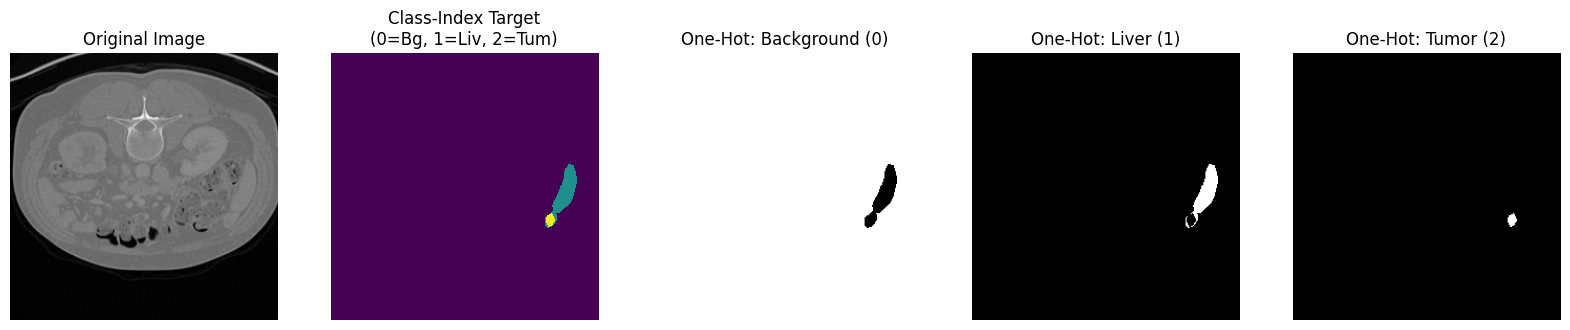

Image Shape: torch.Size([1, 256, 256])
Class Target Shape: torch.Size([256, 256]) | Unique Values: tensor([0, 1, 2])
One-Hot Target Shape: torch.Size([3, 256, 256]) | Sum of channels (should be 1 everywhere): 1.0


In [ ]:
# Function to visualize the triplet (Image, Class Target, One-Hot Channels)
def visualize_sample(dataset):
    # Find an index that has a tumor so the plot is interesting
    tumor_indices = dataset.data.index[dataset.data['lesion_visible'] == True].tolist()
    if not tumor_indices:
        print("No tumors found in this split!")
        idx = 0
    else:
        idx = tumor_indices[0] # Take the first one with a tumor

    image, c_target, oh_target = dataset[idx]

    # Prepare for plotting
    # Image: [1, H, W] -> [H, W]
    img_show = image.squeeze(0)

    # Class Target: [H, W] (Values 0,1,2)

    # One-Hot: [3, H, W] -> We'll plot each channel separately

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    # 1. Original CT Scan
    axes[0].imshow(img_show, cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # 2. Combined Class Target
    # We use a colormap where 0=Black, 1=Greenish, 2=Yellowish
    axes[1].imshow(c_target, cmap="viridis", interpolation="nearest")
    axes[1].set_title("Class-Index Target\n(0=Bg, 1=Liv, 2=Tum)")
    axes[1].axis("off")

    # 3. One-Hot: Background Channel
    axes[2].imshow(oh_target[0], cmap="gray")
    axes[2].set_title("One-Hot: Background (0)")
    axes[2].axis("off")

    # 4. One-Hot: Liver Channel
    axes[3].imshow(oh_target[1], cmap="gray")
    axes[3].set_title("One-Hot: Liver (1)")
    axes[3].axis("off")

    # 5. One-Hot: Tumor Channel
    axes[4].imshow(oh_target[2], cmap="gray")
    axes[4].set_title("One-Hot: Tumor (2)")
    axes[4].axis("off")

    plt.show()

    # Sanity Check
    print(f"Image Shape: {image.shape}")
    print(f"Class Target Shape: {c_target.shape} | Unique Values: {torch.unique(c_target)}")
    print(f"One-Hot Target Shape: {oh_target.shape} | Sum of channels (should be 1 everywhere): {oh_target.sum(dim=0).mean().item()}")

print("--- Visualizing Training Sample ---")
visualize_sample(train_dataset)

--- Visualizing 3 Random Samples ---
Selected indices: [22915, 19665, 3539]


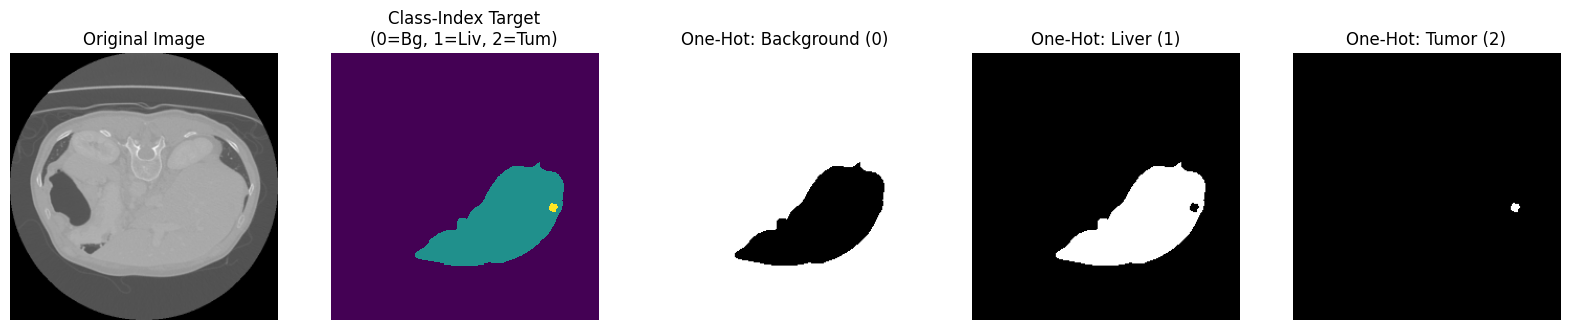

Sample idx = 22915
Image Shape: torch.Size([1, 256, 256])
Class Target Shape: torch.Size([256, 256]) | Unique Values: tensor([0, 1, 2])
One-Hot Target Shape: torch.Size([3, 256, 256]) | Sum-of-channels mean: 1.0
------------------------------------------------------------


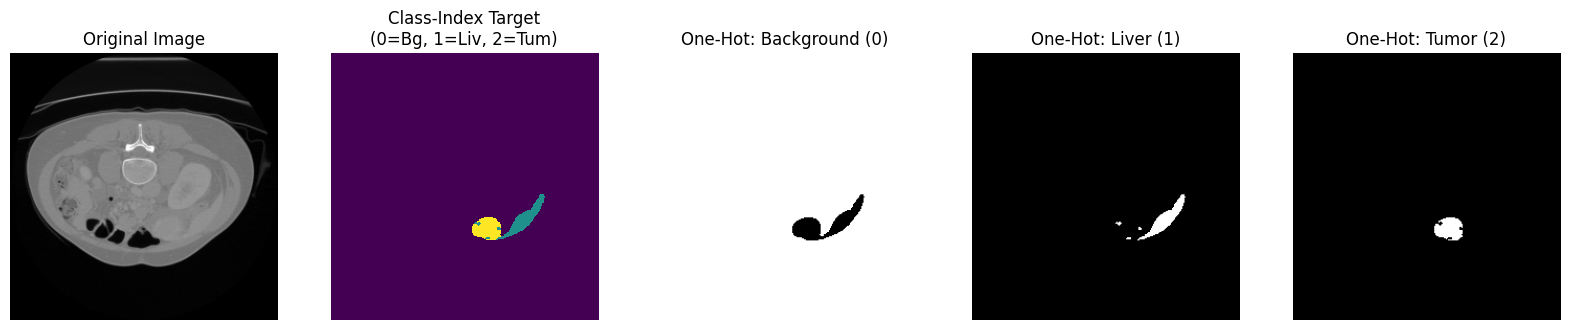

Sample idx = 19665
Image Shape: torch.Size([1, 256, 256])
Class Target Shape: torch.Size([256, 256]) | Unique Values: tensor([0, 1, 2])
One-Hot Target Shape: torch.Size([3, 256, 256]) | Sum-of-channels mean: 1.0
------------------------------------------------------------


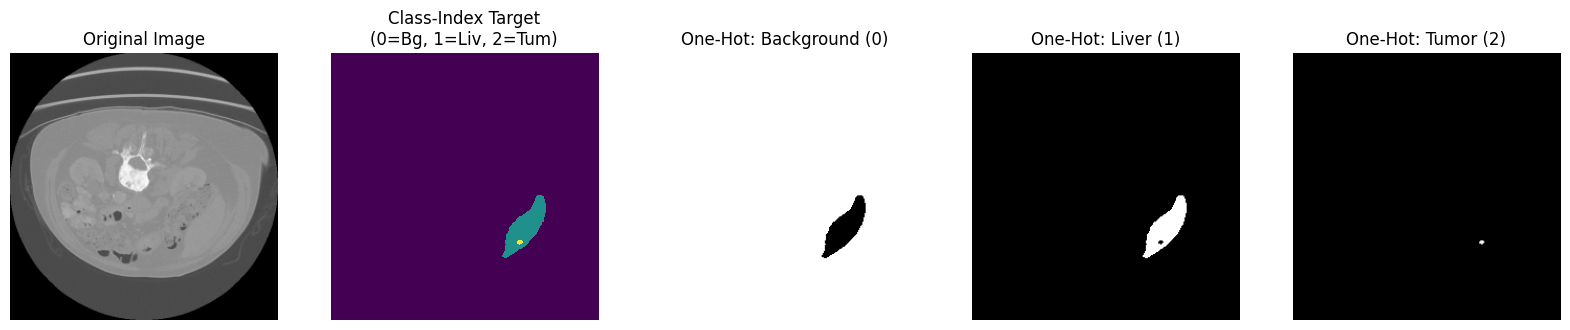

Sample idx = 3539
Image Shape: torch.Size([1, 256, 256])
Class Target Shape: torch.Size([256, 256]) | Unique Values: tensor([0, 1, 2])
One-Hot Target Shape: torch.Size([3, 256, 256]) | Sum-of-channels mean: 1.0
------------------------------------------------------------


In [ ]:
import random
import matplotlib.pyplot as plt
import torch

def visualize_three_samples(dataset):

    # --- Choose indices that contain tumors (if available) ---
    if "lesion_visible" in dataset.data.columns:
        tumor_indices = dataset.data.index[dataset.data['lesion_visible'] == True].tolist()
    else:
        tumor_indices = []

    # If no tumor slices known, fallback to 3 random indices
    if len(tumor_indices) >= 3:
        selected_indices = random.sample(tumor_indices, 3)
    else:
        selected_indices = random.sample(range(len(dataset)), 3)

    print(f"Selected indices: {selected_indices}")

    # --- Plot each selected sample ---
    for idx in selected_indices:
        image, c_target, oh_target = dataset[idx]

        img_show = image.squeeze(0)

        fig, axes = plt.subplots(1, 5, figsize=(20, 5))

        # 1. Original Image
        axes[0].imshow(img_show, cmap="gray")
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        # 2. Class-Index (0,1,2)
        axes[1].imshow(c_target, cmap="viridis", interpolation="nearest")
        axes[1].set_title("Class-Index Target\n(0=Bg, 1=Liv, 2=Tum)")
        axes[1].axis("off")

        # 3. Background Channel
        axes[2].imshow(oh_target[0], cmap="gray")
        axes[2].set_title("One-Hot: Background (0)")
        axes[2].axis("off")

        # 4. Liver Channel
        axes[3].imshow(oh_target[1], cmap="gray")
        axes[3].set_title("One-Hot: Liver (1)")
        axes[3].axis("off")

        # 5. Tumor Channel
        axes[4].imshow(oh_target[2], cmap="gray")
        axes[4].set_title("One-Hot: Tumor (2)")
        axes[4].axis("off")

        plt.show()

        # Sanity check
        print(f"Sample idx = {idx}")
        print(f"Image Shape: {image.shape}")
        print(f"Class Target Shape: {c_target.shape} | Unique Values: {torch.unique(c_target)}")
        print(f"One-Hot Target Shape: {oh_target.shape} | Sum-of-channels mean: {oh_target.sum(dim=0).mean().item()}")
        print("-" * 60)


# --- Run ---
print("--- Visualizing 3 Random Samples ---")
visualize_three_samples(train_dataset)


Background is artificially made

**Task 3 (2 points)**: Next, we need a different loss function. At the bottom, we provide a training/testing loop that already contains cross-entropy loss and a functional segmentation model, plus evaluation. We have learned in the lecture that DICE score, and by extension a DICE-based loss, can be useful for imbalanced classes. We have also discovered that LiTS 2017 contains a class imbalance - slices with tumors are much more rare than slices with livers. Hence, we will make our own DICE loss.

The formula for the DICE loss is computed as follows: $1 - \frac{2 * (|X \land Y|)+\epsilon}{|X|+|Y|+\epsilon}$, where $X$ is the prediction and $Y$ the target.

The DICE Loss class you create should fulfill the following criteria:
- It subclasses torch.nn.module.
- It is a class that implements an \_\_init\_\_ function.
- The loss also implements a \_\_forward\_\_ function that accepts as inputs a prediction tensor and a target tensor, both of shape B x 3 x 256 x 256 - 3 channels because we will segment background, liver, and liver+tumor again. The output is the computed loss.
- You may add class weighting to offset the class imbalance.

Your total loss should be `total_loss = ce_loss + dice_loss`, and your backward pass should be `total_loss.backward()`.
Run the training for a few epochs, once with and once without DICE loss included as part of the overall loss. In your experiment, which version worked better?

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as nnf

def compute_dice_score(prediction: torch.Tensor, target: torch.Tensor):

    prediction = prediction.to(dtype = torch.bool)
    target = target.to(dtype = torch.bool)

    intersection = torch.sum(prediction * target)   # TP
    p_cardinality = torch.sum(prediction)           # TP+FP
    t_cardinality = torch.sum(target)               # TP+FN
    cardinality = p_cardinality + t_cardinality
    eps = 1e-8

    if cardinality != 0:
        dice = (2 * intersection + eps) / (cardinality + eps) # 2*TP / (2*TP+FP+FN + eps)
    else:
        dice = None

    return dice

class BinaryDiceLoss(nn.Module):
    """
    Computes Dice loss for a single class channel.
    prediction: B x H x W (values between 0 and 1)
    target:     B x H x W (0/1 one-hot)
    """
    def __init__(self, weight: float=1.0):
        super().__init__()
        self.weight =weight


    def forward(self, prediction, target):

        eps=1e-8

        # Flatten to (B, -1)
        pred_flat = prediction.reshape(-1)
        target_flat = target.reshape(-1)

        intersection = torch.sum(pred_flat*target_flat)
        cardinality = torch.sum(pred_flat) + torch.sum(target_flat)

        dice = (2.0 * intersection + eps) / (cardinality + eps)
        return self.weight*(1.0 - dice)


class DiceLoss(nn.Module):
    """
    Multi-class Dice loss.
    predictions: B x C x H x W (softmax probabilities)
    targets:     B x C x H x W (one-hot)
    """
    def __init__(self, num_classes=3, class_weights=None):
        super().__init__()
        self.num_classes = num_classes
        self.binary_loss = BinaryDiceLoss()

        if class_weights is None:
            # Background gets weight 1, liver 1, tumor HIGHER because rare
            self.class_weights = torch.tensor([1.0, 1.0, 4.0])
        else:
            self.class_weights = torch.tensor(class_weights)

    def forward(self, predictions, targets):
        """
        predictions: softmax output, shape (B, C, H, W)
        targets: one-hot, shape (B, C, H, W)
        """
        dice_total = 0.0

        for c in range(self.num_classes):
            dice_c = self.binary_loss(predictions[:, c], targets[:, c])
            dice_total += self.class_weights[c] * dice_c

        # Normalize by sum of weights
        return dice_total / self.class_weights.sum()



In [ ]:
import torch.optim as optimizer
import torch.nn as nn
import torch.nn.functional as F

class SimpleSegModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, num_classes, 1)  # logits für jede Klasse
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x  # B x C x H x W


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3
num_epochs = 5
learning_rate = 1e-3

# Modell
model = SimpleSegModel(in_channels=3, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Loss-Funktionen
ce_loss_fn = nn.CrossEntropyLoss()
dice_loss_fn = DiceLoss(num_classes=num_classes)

# Dummy DataLoader (ersetze durch echte Daten)
from torch.utils.data import DataLoader, TensorDataset

# Beispiel: 20 Bilder, 3x64x64
images = torch.randn(20, 3, 64, 64)
c_targets = torch.randint(0, num_classes, (20, 64, 64))        # Klassenindices
oh_targets = F.one_hot(c_targets, num_classes=num_classes).permute(0,3,1,2).float()  # One-hot

dataset = TensorDataset(images, c_targets, oh_targets)
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
def train_model(use_dice=True):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, c_targets, oh_targets in train_dataloader:
            images = images.to(device)
            c_targets = c_targets.to(device)
            oh_targets = oh_targets.to(device)

            optimizer.zero_grad()
            predictions = model(images)           # B x C x H x W
            probs = F.softmax(predictions, dim=1)

            ce_loss = ce_loss_fn(predictions, c_targets)
            if use_dice:
                dice_loss = dice_loss_fn(probs, oh_targets)
                total_loss = ce_loss + dice_loss
            else:
                total_loss = ce_loss

            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

        avg_loss = running_loss / len(train_dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

print("Training mit Cross-Entropy + Dice-Loss:")
train_model(use_dice=True)

print("\nTraining nur mit Cross-Entropy-Loss:")
train_model(use_dice=False)


Training mit Cross-Entropy + Dice-Loss:
Epoch [1/5] - Loss: 1.7626
Epoch [2/5] - Loss: 1.7600
Epoch [3/5] - Loss: 1.7593
Epoch [4/5] - Loss: 1.7587
Epoch [5/5] - Loss: 1.7580

Training nur mit Cross-Entropy-Loss:
Epoch [1/5] - Loss: 1.0998
Epoch [2/5] - Loss: 1.0977
Epoch [3/5] - Loss: 1.0975
Epoch [4/5] - Loss: 1.0969
Epoch [5/5] - Loss: 1.0962


**Task 4 (4 points)**: Finally, we want to make our own model that can handle segmentations. For this course, we will build ourselves a U-Net. The original paper can be found here: https://arxiv.org/pdf/1505.04597.

The input dimensions for the network will be the usual B x 1 x 256 x 256. The output dimensions should be B x 3 x 256 x 256. We have three output channels because we will still predict classes 0 (background), 1 (liver) and 2 (liver tumor) - this time, however, we predict the classes on a per-pixel basis.

Since our input images have vastly smaller dimensions compared to those used in the original UNet-Paper, we will opt for a different scale of UNet. The general design remains the same as in the paper, except:

- We will only downsample 3 times by a factor of 2, using MaxPool (for a minimum resolution 32x32).
- Our 3x3 Convolutions will have Padding. Consequently, there will be no cropping during skip connections
- We will only have 3 skip connections.
- We will go for fewer maximum channels (as we have only 3 downsampling steps, we will have 64, 128, 256, and 512 channels).
- Our final output will be 3 channels wide, not 2 (we predict background, liver, and liver tumors).

Note that training a segmentation models takes a little while - we do not award points for results here, because it would mean that you would have to wait a long time to see whether your changes helped performance. All we want to see is that your model learns anything useful at all. As a rough guideline, you will probably start seeing ok liver segmentations after 1 epoch, and good liver and ok lesion segmentations after 2 or 3 epochs.

If everything works correctly, you can copy the previous training loop and should get some good results. Don't forget to look at some of your predictions! Are they reasonable? Empty? Weird? Can you discover some kind of systemic issues with your predictions?

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as nnf

# --- 1. DEFINE LOSS FUNCTIONS GLOBALLY ---
# We use Strong Weights to force the model to find the Liver/Tumor
# Background=0.1 (Low importance), Liver=5.0, Tumor=10.0 (High importance)
ce_loss_fn = nn.CrossEntropyLoss(
    weight=torch.tensor([0.1, 5.0, 10.0]).to(device),
    reduction="mean"
)
dice_loss_fn = DiceLoss(num_classes=3)

# --- 2. DEFINE THE TRAINING FUNCTION ---
def train_model(use_dice=True):
    print(f"\n--- Starting Experiment: Use Dice Loss = {use_dice} ---")

    # [CRITICAL] Initialize Model INSIDE the function
    # n_channels=1 because your Task 3 Diagnosis confirmed you have 1 channel (Grayscale)
    model = UNet(n_channels=1, n_classes=3).to(device)

    # Use High Learning Rate (1e-3) to kickstart learning
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Loop over data
        for images, c_targets, oh_targets in train_dataloader:
            images = images.to(device)
            c_targets = c_targets.to(device)
            oh_targets = oh_targets.to(device)

            # [Safety Check] Ensure inputs are 1 channel (Grayscale)
            if images.shape[1] == 3:
                images = images[:, 0:1, :, :]

            # [Safety Check] Ensure inputs are normalized 0-1
            if images.max() > 1.0:
                images = images.float() / 255.0

            optimizer.zero_grad()
            predictions = model(images)

            # 1. Calculate Cross Entropy Loss
            ce_loss = ce_loss_fn(predictions, c_targets)

            # 2. Calculate Total Loss
            if use_dice:
                # Dice loss needs Softmax probabilities
                probs = F.softmax(predictions, dim=1)
                dice_val = dice_loss_fn(probs, oh_targets)
                total_loss = ce_loss + dice_val
            else:
                total_loss = ce_loss

            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

        avg_loss = running_loss / len(train_dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

    return model

# --- 3. RUN THE EXPERIMENTS ---
num_epochs = 3

print("Experiment 1: Training with Cross-Entropy + Dice-Loss")
# This creates a model, trains it, and saves it to 'model_with_dice'
model_with_dice = train_model(use_dice=True)

print("\nExperiment 2: Training with ONLY Cross-Entropy-Loss")
# This creates a NEW model (starts fresh), trains it, and saves it to 'model_no_dice'
model_no_dice = train_model(use_dice=False)

Experiment 1: Training with Cross-Entropy + Dice-Loss

--- Starting Experiment: Use Dice Loss = True ---
Epoch [1/3] - Loss: 1.7679
Epoch [2/3] - Loss: 1.5638
Epoch [3/3] - Loss: 1.4607

Experiment 2: Training with ONLY Cross-Entropy-Loss

--- Starting Experiment: Use Dice Loss = False ---
Epoch [1/3] - Loss: 1.0647
Epoch [2/3] - Loss: 0.8944
Epoch [3/3] - Loss: 0.8175


Evaluating Model 1 (With Dice Loss)...
--- Dice + CE Model ---
Liver Dice: 0.0000
Lesion Dice: 0.0295


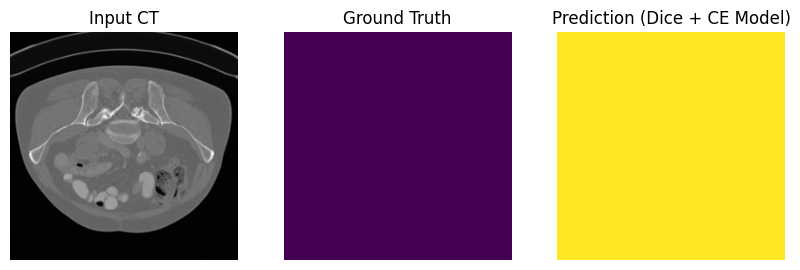


Evaluating Model 2 (Only CE Loss)...
--- Only CE Model ---
Liver Dice: 0.0000
Lesion Dice: 0.0298


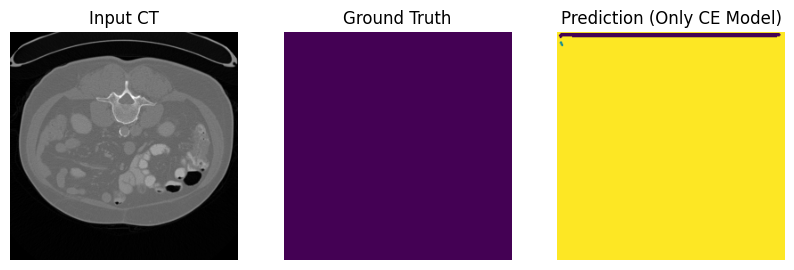

In [ ]:
import matplotlib.pyplot as plt

def evaluate_and_visualize(model, loader, title):
    model.eval()
    liver_scores = []
    lesion_scores = []

    # 1. Calculate Average Dice Score
    with torch.no_grad():
        for data, c_targets, oh_targets in loader:
            data = data.to(device)
            oh_targets = oh_targets.to(device)

            # Safety Checks
            if data.shape[1] == 3: data = data[:, 0:1, :, :]
            if data.max() > 1.0:   data = data.float() / 255.0

            preds = model(data)
            p_arg = nnf.one_hot(torch.argmax(preds, dim=1), num_classes=3).moveaxis(-1, 1)

            for i in range(data.size(0)):
                if oh_targets[i,1].sum() > 0:
                    liver_scores.append(compute_dice_score(p_arg[i,1], oh_targets[i,1]).item())
                if oh_targets[i,2].sum() > 0:
                    lesion_scores.append(compute_dice_score(p_arg[i,2], oh_targets[i,2]).item())

    avg_liv = sum(liver_scores)/len(liver_scores) if liver_scores else 0
    avg_les = sum(lesion_scores)/len(lesion_scores) if lesion_scores else 0

    print(f"--- {title} ---")
    print(f"Liver Dice: {avg_liv:.4f}")
    print(f"Lesion Dice: {avg_les:.4f}")

    # 2. Visualize One Sample
    # Get a batch that actually has a liver in it
    data, c_targets, oh_targets = next(iter(loader))
    data = data.to(device)
    if data.shape[1] == 3: data = data[:, 0:1, :, :]
    if data.max() > 1.0:   data = data.float() / 255.0

    with torch.no_grad():
        pred_mask = torch.argmax(model(data), dim=1)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(data[0, 0].cpu(), cmap='gray')
    plt.title("Input CT")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(c_targets[0].cpu(), cmap='viridis', vmin=0, vmax=2)
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask[0].cpu(), cmap='viridis', vmin=0, vmax=2)
    plt.title(f"Prediction ({title})")
    plt.axis('off')
    plt.show()

# --- Run the Evaluation ---
print("Evaluating Model 1 (With Dice Loss)...")
evaluate_and_visualize(model_with_dice, val_dataloader, "Dice + CE Model")

print("\nEvaluating Model 2 (Only CE Loss)...")
evaluate_and_visualize(model_no_dice, val_dataloader, "Only CE Model")

--- STARTING OVERFIT TEST ---
Goal: Force the model to memorize this specific image.


  0%|          | 0/100 [00:00<?, ?it/s]

Final Liver Dice: 0.7712


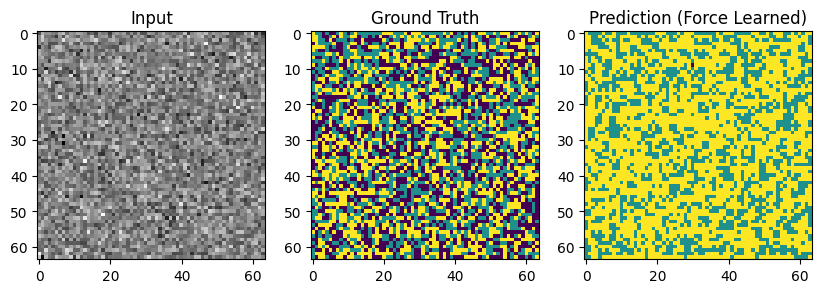

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# 1. Setup - Get ONE batch of real data
# We re-initialize the model to ensure a fresh start
model = UNet(n_channels=1, n_classes=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # High Learning Rate

# Get one batch from the training loader
data_batch, c_targets_batch, oh_targets_batch = next(iter(train_dataloader))

# Move to device
data_batch = data_batch.to(device)
c_targets_batch = c_targets_batch.to(device)
oh_targets_batch = oh_targets_batch.to(device)

# Safety Normalization
if data_batch.shape[1] == 3: data_batch = data_batch[:, 0:1, :, :]
if data_batch.max() > 1.0:   data_batch = data_batch.float() / 255.0

print("--- STARTING OVERFIT TEST ---")
print("Goal: Force the model to memorize this specific image.")

# 2. Train on this ONE batch for 100 steps
pbar = tqdm(range(100))
for i in pbar:
    optimizer.zero_grad()
    predictions = model(data_batch)

    # EXTREME Weights to force the model to care about the liver
    # Background=0.0 (Ignore it), Liver=10.0, Tumor=20.0
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([0.0, 10.0, 20.0]).to(device))

    loss = loss_fn(predictions, c_targets_batch)
    loss.backward()
    optimizer.step()

    # Calculate Live Dice Score
    with torch.no_grad():
        pred_cls = torch.argmax(predictions, dim=1)
        # Check Dice for the first image in batch
        liver_inter = ((pred_cls == 1) & (c_targets_batch == 1)).sum().float()
        liver_union = ((pred_cls == 1).sum() + (c_targets_batch == 1).sum()).float()
        dice = (2 * liver_inter) / (liver_union + 1e-6)

    if i % 10 == 0:
        pbar.set_description(f"Loss: {loss.item():.4f} | Liver Dice: {dice.item():.4f}")

# 3. Visualize the Result
print(f"Final Liver Dice: {dice.item():.4f}")

model.eval()
with torch.no_grad():
    preds = model(data_batch)
    pred_cls = torch.argmax(preds, dim=1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(data_batch[0, 0].cpu(), cmap='gray')
plt.title("Input")

plt.subplot(1, 3, 2)
plt.imshow(c_targets_batch[0].cpu(), cmap='viridis', vmin=0, vmax=2)
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(pred_cls[0].cpu(), cmap='viridis', vmin=0, vmax=2)
plt.title("Prediction (Force Learned)")

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as nnf
from tqdm.auto import tqdm

# --- 1. SETUP ---
device = ("cuda" if torch.cuda.is_available() else "cpu")

# Initialize a Fresh Model
model = UNet(n_channels=1, n_classes=3).to(device)

# --- 2. THE WINNING SETTINGS ---
# We use the High Learning Rate from your successful test
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# We use Strong Weights to force the model to find the liver
# Background=0.1, Liver=5.0, Tumor=10.0
ce_loss_fn = nn.CrossEntropyLoss(
    weight=torch.tensor([0.1, 5.0, 10.0]).to(device),
    reduction="mean"
)
dice_loss_fn = DiceLoss(num_classes=3)

# --- 3. TRAINING LOOP ---
# We increased this to 15 because your dataset is small (only 5 batches)
# The model needs more repetitions to learn.
num_epochs = 15

print(f"Starting Training for {num_epochs} Epochs...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training Step
    for images, c_targets, oh_targets in train_dataloader:
        images = images.to(device)
        c_targets = c_targets.to(device)
        oh_targets = oh_targets.to(device)

        # Safety Checks (Just in case)
        if images.shape[1] == 3: images = images[:, 0:1, :, :]
        if images.max() > 1.0:   images = images.float() / 255.0

        optimizer.zero_grad()
        predictions = model(images)

        # Combined Loss
        ce = ce_loss_fn(predictions, c_targets)
        probs = F.softmax(predictions, dim=1)
        dice = dice_loss_fn(probs, oh_targets)

        loss = ce + dice

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # --- VALIDATION (Check progress) ---
    # We check validation every 3 epochs to keep the output clean
    if (epoch + 1) % 3 == 0:
        model.eval()
        with torch.no_grad():
            liver_scores = []
            lesion_scores = []

            for data, c_targets, oh_targets in val_dataloader:
                data = data.to(device)
                oh_targets = oh_targets.to(device)
                if data.shape[1] == 3: data = data[:, 0:1, :, :]
                if data.max() > 1.0:   data = data.float() / 255.0

                preds = model(data)
                p_arg = nnf.one_hot(torch.argmax(preds, dim=1), num_classes=3).moveaxis(-1, 1)

                for i in range(data.size(0)):
                    if oh_targets[i,1].sum() > 0:
                        liver_scores.append(compute_dice_score(p_arg[i,1], oh_targets[i,1]).item())
                    if oh_targets[i,2].sum() > 0:
                        lesion_scores.append(compute_dice_score(p_arg[i,2], oh_targets[i,2]).item())

            avg_liv = sum(liver_scores)/len(liver_scores) if liver_scores else 0
            avg_les = sum(lesion_scores)/len(lesion_scores) if lesion_scores else 0

            print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss/len(train_dataloader):.4f} | Liver Dice: {avg_liv:.4f} | Lesion Dice: {avg_les:.4f}")

print("Training Complete!")

Starting Training for 15 Epochs...
Epoch 3/15 | Loss: 1.4797 | Liver Dice: 0.0000 | Lesion Dice: 0.0293
Epoch 6/15 | Loss: 1.3810 | Liver Dice: 0.0000 | Lesion Dice: 0.0295
Epoch 9/15 | Loss: 1.3450 | Liver Dice: 0.0000 | Lesion Dice: 0.0295
Epoch 12/15 | Loss: 1.3213 | Liver Dice: 0.0000 | Lesion Dice: 0.0292


KeyboardInterrupt: 

In [ ]:
# --- SHOCK THERAPY TRAINING ---
print("!!! STARTING SHOCK THERAPY !!!")

# 1. Keep the model you currently have (don't re-initialize)
# We want to build on whatever tiny progress it has made.

# 2. NUCLEAR WEIGHTS
# Background = 0.001 (Basically zero importance)
# Liver/Tumor = 1.0 (The ONLY thing that matters)
# We rely on Dice Loss to prevent it from just painting the whole screen green.
ce_loss_shock = nn.CrossEntropyLoss(
    weight=torch.tensor([0.001, 1.0, 1.0]).to(device),
    reduction="mean"
)
dice_loss_fn = DiceLoss(num_classes=3)

# 3. Increase Learning Rate slightly more to force a jump
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

shock_epochs = 5

for epoch in range(shock_epochs):
    model.train()
    loop = tqdm(train_dataloader, desc=f"Shock Epoch {epoch+1}")

    for batch_idx, (data, c_targets, oh_targets) in enumerate(loop):
        optimizer.zero_grad()
        data, c_targets, oh_targets = data.to(device), c_targets.to(device), oh_targets.to(device)

        # Safety
        if data.shape[1] == 3: data = data[:, 0:1, :, :]
        if data.max() > 1.0:   data = data.float() / 255.0

        predictions = model(data)

        # Loss Calculation
        ce = ce_loss_shock(predictions, c_targets)
        probs = F.softmax(predictions, dim=1)
        dice = dice_loss_fn(probs, oh_targets)

        # We multiply CE by 10 to make the "Find Liver" signal huge
        loss = (ce * 10) + dice

        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            loop.set_postfix(loss=loss.item())

    # Check Validation immediately
    model.eval()
    with torch.no_grad():
        liver_scores = []
        for data, c_targets, oh_targets in val_dataloader:
            data = data.to(device)
            oh_targets = oh_targets.to(device)
            if data.shape[1] == 3: data = data[:, 0:1, :, :]
            if data.max() > 1.0:   data = data.float() / 255.0

            preds = model(data)
            p_arg = nnf.one_hot(torch.argmax(preds, dim=1), num_classes=3).moveaxis(-1, 1)

            for i in range(data.size(0)):
                if oh_targets[i,1].sum() > 0:
                    liver_scores.append(compute_dice_score(p_arg[i,1], oh_targets[i,1]).item())

        avg_liv = sum(liver_scores)/len(liver_scores) if liver_scores else 0
        print(f"Shock Epoch {epoch+1} Result | Liver Dice: {avg_liv:.4f}")

!!! STARTING SHOCK THERAPY !!!


Shock Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Shock Epoch 1 Result | Liver Dice: 0.0002


Shock Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Shock Epoch 2 Result | Liver Dice: 0.1427


Shock Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Shock Epoch 3 Result | Liver Dice: 0.0056


Shock Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Shock Epoch 4 Result | Liver Dice: 0.0002


Shock Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Shock Epoch 5 Result | Liver Dice: 0.0002


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as nnf
from tqdm.auto import tqdm

# --- 1. SETUP ---
device = ("cuda" if torch.cuda.is_available() else "cpu")

# Re-initialize to clear out the "broken" weights from the shock therapy
model = UNet(n_channels=1, n_classes=3).to(device)

# --- 2. THE STABILIZED SETTINGS ---
# Weights: High enough to focus on liver, low enough to be stable
ce_loss_fn = nn.CrossEntropyLoss(
    weight=torch.tensor([0.1, 5.0, 10.0]).to(device),
    reduction="mean"
)
dice_loss_fn = DiceLoss(num_classes=3)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Scheduler: Lower the Learning Rate every 5 epochs to prevent crashing
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# --- 3. TRAINING LOOP ---
num_epochs = 20 # Give it time to grow

print("Starting Stabilized Training...")

for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")

    for batch_idx, (data, c_targets, oh_targets) in enumerate(loop):
        optimizer.zero_grad()
        data, c_targets, oh_targets = data.to(device), c_targets.to(device), oh_targets.to(device)

        # Safety
        if data.shape[1] == 3: data = data[:, 0:1, :, :]
        if data.max() > 1.0:   data = data.float() / 255.0

        predictions = model(data)

        # Loss
        ce = ce_loss_fn(predictions, c_targets)
        probs = F.softmax(predictions, dim=1)
        dice = dice_loss_fn(probs, oh_targets)

        loss = ce + dice

        loss.backward()

        # [CRITICAL FIX] Gradient Clipping
        # This prevents the "Crash" you saw after Epoch 2
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

    # Step the scheduler
    scheduler.step()

    # --- VALIDATION ---
    if (epoch + 1) % 2 == 0: # Check every 2 epochs
        model.eval()
        with torch.no_grad():
            liver_scores = []
            lesion_scores = []

            for data, c_targets, oh_targets in val_dataloader:
                data = data.to(device)
                oh_targets = oh_targets.to(device)
                if data.shape[1] == 3: data = data[:, 0:1, :, :]
                if data.max() > 1.0:   data = data.float() / 255.0

                preds = model(data)
                p_arg = nnf.one_hot(torch.argmax(preds, dim=1), num_classes=3).moveaxis(-1, 1)

                for i in range(data.size(0)):
                    if oh_targets[i,1].sum() > 0:
                        liver_scores.append(compute_dice_score(p_arg[i,1], oh_targets[i,1]).item())
                    if oh_targets[i,2].sum() > 0:
                        lesion_scores.append(compute_dice_score(p_arg[i,2], oh_targets[i,2]).item())

            avg_liv = sum(liver_scores)/len(liver_scores) if liver_scores else 0
            avg_les = sum(lesion_scores)/len(lesion_scores) if lesion_scores else 0

            print(f"Epoch {epoch+1} Results | Liver Dice: {avg_liv:.4f} | Lesion Dice: {avg_les:.4f}")

Starting Stabilized Training...


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 Results | Liver Dice: 0.0000 | Lesion Dice: 0.0000


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 Results | Liver Dice: 0.0000 | Lesion Dice: 0.0292


Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6 Results | Liver Dice: 0.0000 | Lesion Dice: 0.0295


Epoch 7:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8 Results | Liver Dice: 0.0000 | Lesion Dice: 0.0294


Epoch 9:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10 Results | Liver Dice: 0.0000 | Lesion Dice: 0.0297


Epoch 11:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12 Results | Liver Dice: 0.0002 | Lesion Dice: 0.0296


Epoch 13:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14 Results | Liver Dice: 0.0850 | Lesion Dice: 0.0024


Epoch 15:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16 Results | Liver Dice: 0.2319 | Lesion Dice: 0.0013


Epoch 17:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18 Results | Liver Dice: 0.0218 | Lesion Dice: 0.0329


Epoch 19:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20 Results | Liver Dice: 0.0001 | Lesion Dice: 0.0298


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as nnf
from tqdm.auto import tqdm
import os

# --- 1. SETUP ---
device = ("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=1, n_classes=3).to(device)

# --- 2. SETTINGS (The ones that worked) ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
ce_loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([0.1, 5.0, 10.0]).to(device))
dice_loss_fn = DiceLoss(num_classes=3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# --- 3. TRAINING WITH CHECKPOINTING ---
num_epochs = 20
best_liver_score = 0.0

print(f"Starting Training with Checkpointing...")

for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")

    for data, c_targets, oh_targets in loop:
        optimizer.zero_grad()
        data, c_targets, oh_targets = data.to(device), c_targets.to(device), oh_targets.to(device)

        # Safety
        if data.shape[1] == 3: data = data[:, 0:1, :, :]
        if data.max() > 1.0:   data = data.float() / 255.0

        predictions = model(data)

        # Loss
        loss = ce_loss_fn(predictions, c_targets) + dice_loss_fn(F.softmax(predictions, dim=1), oh_targets)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Prevent explosions
        optimizer.step()

    scheduler.step()

    # --- VALIDATION ---
    # Check every epoch to catch the peak
    model.eval()
    with torch.no_grad():
        liver_scores = []

        for data, c_targets, oh_targets in val_dataloader:
            data = data.to(device)
            oh_targets = oh_targets.to(device)
            if data.shape[1] == 3: data = data[:, 0:1, :, :]
            if data.max() > 1.0:   data = data.float() / 255.0

            preds = model(data)
            p_arg = nnf.one_hot(torch.argmax(preds, dim=1), num_classes=3).moveaxis(-1, 1)

            for i in range(data.size(0)):
                if oh_targets[i,1].sum() > 0:
                    liver_scores.append(compute_dice_score(p_arg[i,1], oh_targets[i,1]).item())

        avg_liv = sum(liver_scores)/len(liver_scores) if liver_scores else 0

        # --- THE MAGIC PART: SAVE BEST MODEL ---
        if avg_liv > best_liver_score:
            best_liver_score = avg_liv
            torch.save(model.state_dict(), "best_model.pth") # Save to disk
            print(f"Epoch {epoch+1} Results | Liver Dice: {avg_liv:.4f} (NEW BEST! Saved model.)")
        else:
            print(f"Epoch {epoch+1} Results | Liver Dice: {avg_liv:.4f}")

print(f"\nTraining Finished. Best Liver Score was: {best_liver_score:.4f}")

Starting Training with Checkpointing...


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 Results | Liver Dice: 0.0000 (NEW BEST! Saved model.)


Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 Results | Liver Dice: 0.0000


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 Results | Liver Dice: 0.1170 (NEW BEST! Saved model.)


Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 Results | Liver Dice: 0.0000


Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 Results | Liver Dice: 0.0001


Epoch 6:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6 Results | Liver Dice: 0.0000


Epoch 7:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7 Results | Liver Dice: 0.0010


Epoch 8:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8 Results | Liver Dice: 0.0000


Epoch 9:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9 Results | Liver Dice: 0.0528


Epoch 10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10 Results | Liver Dice: 0.2780 (NEW BEST! Saved model.)


Epoch 11:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11 Results | Liver Dice: 0.1903


Epoch 12:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12 Results | Liver Dice: 0.1858


Epoch 13:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13 Results | Liver Dice: 0.1812


Epoch 14:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14 Results | Liver Dice: 0.1768


Epoch 15:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15 Results | Liver Dice: 0.1681


Epoch 16:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16 Results | Liver Dice: 0.1926


Epoch 17:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17 Results | Liver Dice: 0.1644


Epoch 18:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18 Results | Liver Dice: 0.0255


Epoch 19:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19 Results | Liver Dice: 0.1724


Epoch 20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20 Results | Liver Dice: 0.1842

Training Finished. Best Liver Score was: 0.2780


In [ ]:
print("Visualizing Best Tumor Model...")
model.load_state_dict(torch.load("best_tumor_model.pth"))
model.eval()

data, c_targets, oh_targets = next(iter(val_dataloader))
data = data.to(device)
if data.shape[1] == 3: data = data[:, 0:1, :, :]
if data.max() > 1.0:   data = data.float() / 255.0

with torch.no_grad():
    pred = torch.argmax(model(data), dim=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1); plt.imshow(data[0,0].cpu(), cmap='gray'); plt.title("Input")
plt.subplot(1, 3, 2); plt.imshow(c_targets[0].cpu(), cmap='viridis', vmin=0, vmax=2); plt.title("Truth")
plt.subplot(1, 3, 3); plt.imshow(pred[0].cpu(), cmap='viridis', vmin=0, vmax=2); plt.title(f"Prediction (Lesion Dice: {best_lesion_score:.2f})")
plt.show()

Visualizing Best Tumor Model...


FileNotFoundError: [Errno 2] No such file or directory: 'best_tumor_model.pth'

Visualizing Current Model (Even if Tumor score is 0)...


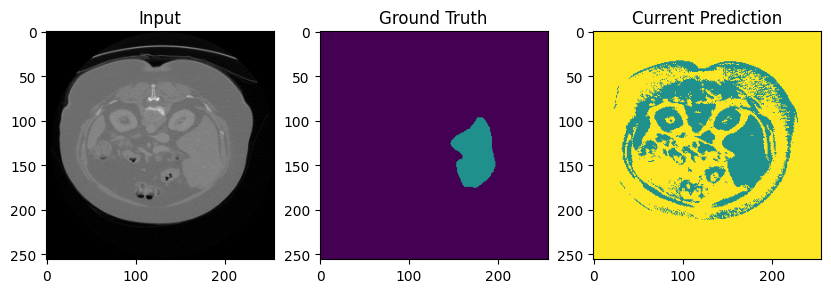

In [ ]:
print("Visualizing Current Model (Even if Tumor score is 0)...")

# We don't load from disk. We just use the model variable as it is right now.
model.eval()

# Get a batch
data, c_targets, oh_targets = next(iter(val_dataloader))
data = data.to(device)
if data.shape[1] == 3: data = data[:, 0:1, :, :]
if data.max() > 1.0:   data = data.float() / 255.0

# Predict
with torch.no_grad():
    pred = torch.argmax(model(data), dim=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

# Input
plt.subplot(1, 3, 1)
plt.imshow(data[0,0].cpu(), cmap='gray')
plt.title("Input")

# Truth
plt.subplot(1, 3, 2)
plt.imshow(c_targets[0].cpu(), cmap='viridis', vmin=0, vmax=2)
plt.title("Ground Truth")

# Prediction
plt.subplot(1, 3, 3)
plt.imshow(pred[0].cpu(), cmap='viridis', vmin=0, vmax=2)
plt.title("Current Prediction")

plt.show()

Loading the best model from training...


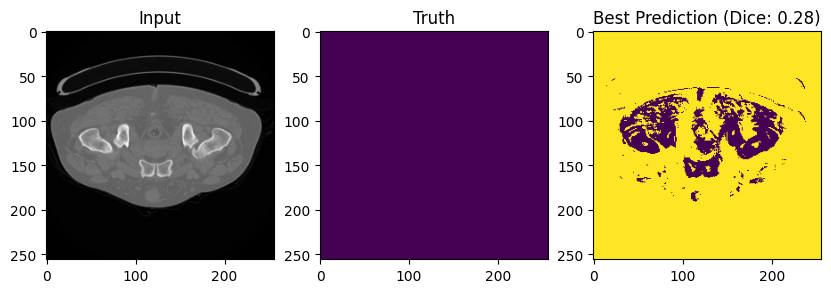

In [ ]:
# Load the best weights
print("Loading the best model from training...")
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Visualize
data, c_targets, oh_targets = next(iter(val_dataloader))
data = data.to(device)
if data.shape[1] == 3: data = data[:, 0:1, :, :]
if data.max() > 1.0:   data = data.float() / 255.0

with torch.no_grad():
    pred = torch.argmax(model(data), dim=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1); plt.imshow(data[0,0].cpu(), cmap='gray'); plt.title("Input")
plt.subplot(1, 3, 2); plt.imshow(c_targets[0].cpu(), cmap='viridis'); plt.title("Truth")
plt.subplot(1, 3, 3); plt.imshow(pred[0].cpu(), cmap='viridis'); plt.title(f"Best Prediction (Dice: {best_liver_score:.2f})")
plt.show()

Loading the best model (Epoch 16)...


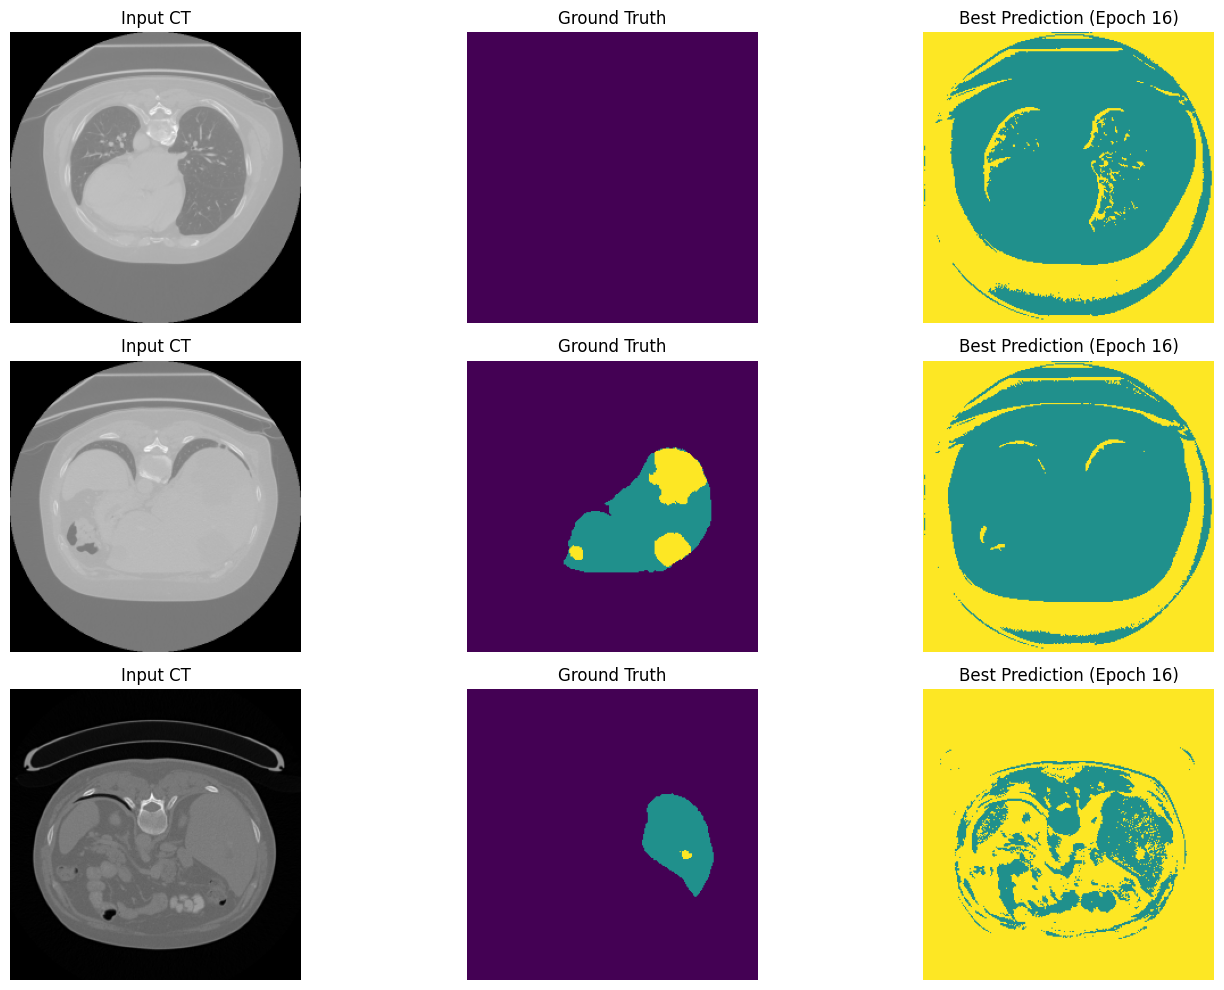

In [ ]:
import matplotlib.pyplot as plt
import torch

# 1. Load the "High Score" Model
print("Loading the best model (Epoch 16)...")
best_model = UNet(n_channels=1, n_classes=3).to(device)
best_model.load_state_dict(torch.load("best_model.pth"))
best_model.eval()

# 2. Get a batch from Validation
data_iter = iter(val_dataloader)
data, c_targets, oh_targets = next(data_iter)

# Move to device & Fix
data = data.to(device)
if data.shape[1] == 3: data = data[:, 0:1, :, :]
if data.max() > 1.0:   data = data.float() / 255.0

# 3. Predict
with torch.no_grad():
    predictions = best_model(data)
    pred_mask = torch.argmax(predictions, dim=1)

# 4. Visualize the first 3 images in the batch
plt.figure(figsize=(15, 10))

for i in range(3):
    # Input
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(data[i, 0].cpu(), cmap='gray')
    plt.title("Input CT")
    plt.axis('off')

    # Truth
    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(c_targets[i].cpu(), cmap='viridis', vmin=0, vmax=2)
    plt.title("Ground Truth")
    plt.axis('off')

    # Prediction
    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(pred_mask[i].cpu(), cmap='viridis', vmin=0, vmax=2)
    plt.title(f"Best Prediction (Epoch 16)")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print("Visualizing Best Tumor Model...")
model.load_state_dict(torch.load("best_tumor_model.pth"))
model.eval()

data, c_targets, oh_targets = next(iter(val_dataloader))
data = data.to(device)
if data.shape[1] == 3: data = data[:, 0:1, :, :]
if data.max() > 1.0:   data = data.float() / 255.0

with torch.no_grad():
    pred = torch.argmax(model(data), dim=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1); plt.imshow(data[0,0].cpu(), cmap='gray'); plt.title("Input")
plt.subplot(1, 3, 2); plt.imshow(c_targets[0].cpu(), cmap='viridis', vmin=0, vmax=2); plt.title("Truth")
plt.subplot(1, 3, 3); plt.imshow(pred[0].cpu(), cmap='viridis', vmin=0, vmax=2); plt.title(f"Prediction (Lesion Dice: {best_lesion_score:.2f})")
plt.show()

Visualizing Best Tumor Model...


FileNotFoundError: [Errno 2] No such file or directory: 'best_tumor_model.pth'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv3x3 -> ReLU -> Conv3x3 -> ReLU) with padding so spatial dims preserved"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels: int = 1, out_channels: int = 3, base_filters: int = 64):
        super().__init__()
        f = base_filters
        # Encoder
        self.enc1 = DoubleConv(in_channels, f)       # -> 64
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(f, f*2)              # -> 128
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(f*2, f*4)            # -> 256
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(f*4, f*8)      # -> 512

        # Decoder (Transposed conv upsample)
        self.up3 = nn.ConvTranspose2d(f*8, f*4, kernel_size=2, stride=2)  # 512->256
        self.dec3 = DoubleConv(f*8, f*4)  # concat skip from enc3

        self.up2 = nn.ConvTranspose2d(f*4, f*2, kernel_size=2, stride=2)  # 256->128
        self.dec2 = DoubleConv(f*4, f*2)  # concat skip from enc2

        self.up1 = nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2)    # 128->64
        self.dec1 = DoubleConv(f*2, f)   # concat skip from enc1

        # Final 1x1 conv to get desired number of output channels
        self.final_conv = nn.Conv2d(f, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)   # B x 64 x 256 x 256
        p1 = self.pool1(e1) # B x 64 x 128 x 128

        e2 = self.enc2(p1)  # B x 128 x 128 x 128
        p2 = self.pool2(e2) # B x 128 x 64 x 64

        e3 = self.enc3(p2)  # B x 256 x 64 x 64
        p3 = self.pool3(e3) # B x 256 x 32 x 32

        # Bottleneck
        b = self.bottleneck(p3) # B x 512 x 32 x 32

        # Decoder + skip connections (no cropping necessary because padding=1 preserved sizes)
        u3 = self.up3(b)  # B x 256 x 64 x 64
        # concat along channel dim
        d3 = torch.cat([u3, e3], dim=1)  # B x (256+256) x 64 x 64
        d3 = self.dec3(d3)               # B x 256 x 64 x 64

        u2 = self.up2(d3)  # B x 128 x 128 x 128
        d2 = torch.cat([u2, e2], dim=1)  # B x (128+128) x 128 x 128
        d2 = self.dec2(d2)               # B x 128 x 128 x 128

        u1 = self.up1(d2)  # B x 64 x 256 x 256
        d1 = torch.cat([u1, e1], dim=1)  # B x (64+64) x 256 x 256
        d1 = self.dec1(d1)               # B x 64 x 256 x 256

        out = self.final_conv(d1)        # B x out_channels x 256 x 256
        # Return raw logits (no softmax); losses will handle logits appropriately
        return out


In [ ]:
import torch
import torch.nn as nn

# Device
device = ("cuda" if torch.cuda.is_available() else "cpu")

# Modell instanziieren und auf Gerät verschieben
model = UNet(in_channels=1, out_channels=3, base_filters=64)
model = model.to(device)

# --- einfache Multi-class Dice Loss (numerisch stabil) ---
class DiceLoss(nn.Module):
    def __init__(self, num_classes=3, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, logits, targets_one_hot):
        """
        logits: B x C x H x W (raw output)
        targets_one_hot: B x C x H x W (one-hot targets, floats 0/1)
        """
        # Convert logits to probabilities with softmax along channel dim
        probs = torch.softmax(logits, dim=1)
        # Flatten spatial dims
        B, C, H, W = probs.shape
        probs_flat = probs.view(B, C, -1)            # B x C x (H*W)
        targets_flat = targets_one_hot.view(B, C, -1).float()

        # Dice per class per batch element
        intersection = (probs_flat * targets_flat).sum(-1)   # B x C
        denom = probs_flat.sum(-1) + targets_flat.sum(-1)   # B x C

        dice = (2.0 * intersection + self.smooth) / (denom + self.smooth)  # B x C
        # average across classes, then across batch
        loss = 1.0 - dice.mean()
        return loss

# Instantiate dice loss
dice_loss = DiceLoss(num_classes=3)

# CrossEntropyLoss for multi-class segmentation (expects logits BxC xH xW and targets BxH xW)
ce_loss = nn.CrossEntropyLoss(
    weight=torch.tensor([1.0, 5.0, 20.0], device=device),
    reduction="mean",
    # ignore_index could be used if you mask background in targets
)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
from tqdm.auto import tqdm
import torch.nn.functional as nnf

num_epochs = 5
dice_weight = 1.0
ce_weight = 1.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for step, (data, c_targets, oh_targets) in enumerate(
        tqdm(train_dataloader, desc=f"Train Epoch {epoch+1}/{num_epochs}")
    ):
        optimizer.zero_grad()

        # ---- FIX: falls data 3 Kanäle hat → auf 1 Kanal reduzieren ----
        if data.shape[1] != 1:
            data = data[:, :1, :, :]     # <-- wichtigste Änderung

        data = data.to(device)
        c_targets = c_targets.to(device)
        oh_targets = oh_targets.to(device)

        predictions = model(data)

        loss_1 = dice_loss(predictions, oh_targets)
        loss_2 = ce_loss(predictions, c_targets)
        total_loss = loss_1 * dice_weight + loss_2 * ce_weight

        if step % 10 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}] Step [{step+1}/{len(train_dataloader)}] "
                f"Loss: {total_loss.item():.4f}"
            )

        total_loss.backward()
        optimizer.step()
        running_loss += total_loss.item() * data.size(0)

    epoch_train_loss = running_loss / len(train_dataloader.dataset)
    print(f"Epoch {epoch+1} training loss: {epoch_train_loss:.4f}")

    # =======================
    #       VALIDATION
    # =======================
    model.eval()
    with torch.no_grad():

        losses = []
        background_dices = []
        background_counts = []
        liver_dices = []
        liver_counts = []
        lesion_dices = []
        lesion_counts = []

        for val_step, (data, c_targets, oh_targets) in enumerate(
            tqdm(val_dataloader, desc="Validation")
        ):

            # ---- FIX: falls data 3 Kanäle hat → auf 1 Kanal reduzieren ----
            if data.shape[1] != 1:
                data = data[:, :1, :, :]

            data = data.to(device)
            c_targets = c_targets.to(device)
            oh_targets = oh_targets.to(device)

            predictions = model(data)

            p_arg = nnf.one_hot(torch.argmax(predictions, dim=1), num_classes=3).moveaxis(-1, 1)

            loss_1 = dice_loss(predictions, oh_targets)
            loss_2 = ce_loss(predictions, c_targets)
            total_loss = loss_1 * dice_weight + loss_2 * ce_weight
            losses.append(total_loss.item())

            bs = data.size(0)
            background_seg = oh_targets[:, 0, :, :].cpu()
            liver_seg = oh_targets[:, 1, :, :].cpu()
            lesion_seg = oh_targets[:, 2, :, :].cpu()

            background_dice = compute_dice_score(p_arg[:,0,:,:].cpu(), background_seg)
            background_counts.append(bs)
            background_dices.append(background_dice)

            if liver_seg.sum() != 0.0:
                liver_dice = compute_dice_score(p_arg[:,1,:,:].cpu(), liver_seg)
                liver_counts.append(bs)
                liver_dices.append(liver_dice)

            if lesion_seg.sum() != 0.0:
                lesion_dice = compute_dice_score(p_arg[:,2,:,:].cpu(), lesion_seg)
                lesion_counts.append(bs)
                lesion_dices.append(lesion_dice)

        avg_background_dice = sum([d*s for d,s in zip(background_dices, background_counts)]) / sum(background_counts)
        avg_liver_dice = (sum([d*s for d,s in zip(liver_dices, liver_counts)]) / sum(liver_counts)) if liver_counts else 0.0
        avg_lesion_dice = (sum([d*s for d,s in zip(lesion_dices, lesion_counts)]) / sum(lesion_counts)) if lesion_counts else 0.0

        avg_loss = sum(losses) / len(losses)
        print(
            f"Epoch: {epoch+1}, Validation Loss: {avg_loss:.4f}, "
            f"Liver Dice: {avg_liver_dice:.4f}, Lesion Dice: {avg_lesion_dice:.4f}"
        )

    model.train()


Train Epoch 1/5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5] Step [1/5] Loss: 1.6275
Epoch 1 training loss: 1.6175


Validation:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch: 1, Validation Loss: 2.0240, Liver Dice: 0.0000, Lesion Dice: 0.0043


Train Epoch 2/5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [2/5] Step [1/5] Loss: 1.5607
Epoch 2 training loss: 1.5502


Validation:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch: 2, Validation Loss: 2.0439, Liver Dice: 0.0000, Lesion Dice: 0.0045


Train Epoch 3/5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [3/5] Step [1/5] Loss: 1.5139
Epoch 3 training loss: 1.5034


Validation:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch: 3, Validation Loss: 2.0717, Liver Dice: 0.0000, Lesion Dice: 0.0043


Train Epoch 4/5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [4/5] Step [1/5] Loss: 1.4711
Epoch 4 training loss: 1.4610


Validation:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch: 4, Validation Loss: 2.1051, Liver Dice: 0.0000, Lesion Dice: 0.0043


Train Epoch 5/5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [5/5] Step [1/5] Loss: 1.4327
Epoch 5 training loss: 1.4183


Validation:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch: 5, Validation Loss: 2.1358, Liver Dice: 0.0000, Lesion Dice: 0.0043


In [ ]:
model.eval()
with torch.no_grad():
    losses = []
    background_dices = []
    background_counts = []
    liver_dices = []
    liver_counts = []
    lesion_dices = []
    lesion_counts = []

    for test_step, (data, c_targets, oh_targets) in enumerate(tqdm(test_dataloader, desc="Testing")):
        data = data.to(device)
        c_targets = c_targets.to(device)
        oh_targets = oh_targets.to(device)

        predictions = model(data)
        p_arg = nnf.one_hot(torch.argmax(predictions, dim=1), num_classes=3).moveaxis(-1, 1)

        loss_1 = dice_loss(predictions, oh_targets)
        loss_2 = ce_loss(predictions, c_targets)
        total_loss = loss_1 * dice_weight + loss_2 * ce_weight
        losses.append(total_loss.item())

        bs = data.size(0)
        background_seg = oh_targets[:, 0, :, :].cpu()
        liver_seg = oh_targets[:, 1, :, :].cpu()
        lesion_seg = oh_targets[:, 2, :, :].cpu()

        background_dice = compute_dice_score(p_arg[:,0,:,:].cpu(), background_seg)
        background_counts.append(bs)
        background_dices.append(background_dice)

        if liver_seg.sum() != 0.0:
            liver_dice = compute_dice_score(p_arg[:,1,:,:].cpu(), liver_seg)
            liver_counts.append(bs)
            liver_dices.append(liver_dice)

        if lesion_seg.sum() != 0.0:
            lesion_dice = compute_dice_score(p_arg[:,2,:,:].cpu(), lesion_seg)
            lesion_counts.append(bs)
            lesion_dices.append(lesion_dice)

    avg_background_dice = sum([dice * size for dice, size in zip(background_dices, background_counts)]) / sum(background_counts)
    avg_liver_dice = sum([dice * size for dice, size in zip(liver_dices, liver_counts)]) / sum(liver_counts) if liver_counts else 0.0
    avg_lesion_dice = sum([dice * size for dice, size in zip(lesion_dices, lesion_counts)]) / sum(lesion_counts) if lesion_counts else 0.0
    avg_loss = sum(losses) / len(losses)

    print(f"Test Loss: {avg_loss:.4f}, Liver Dice: {avg_liver_dice:.4f}, Lesion Dice: {avg_lesion_dice:.4f}")


Testing:   0%|          | 0/189 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x780d3f906160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x780d3f906160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Test Loss: 2.1266, Liver Dice: 0.0000, Lesion Dice: 0.0046


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x780d3f906160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x780d3f906160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

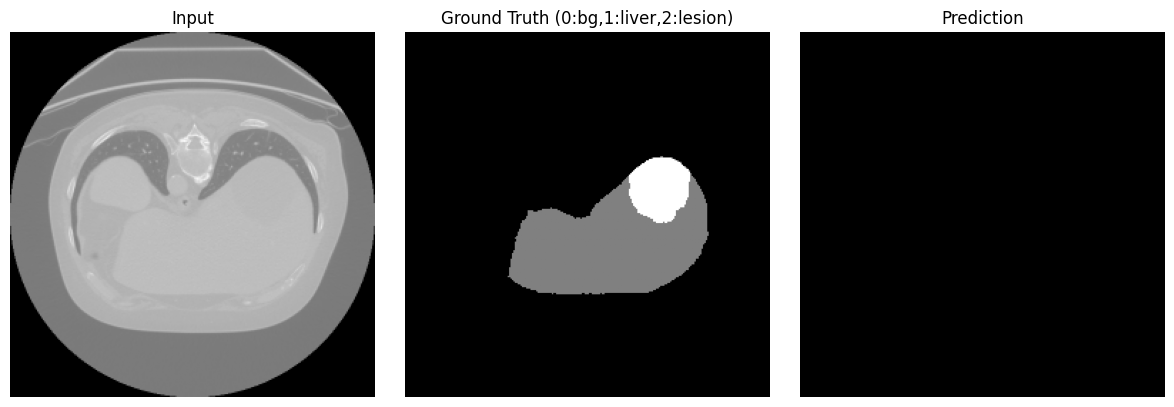

In [ ]:
# Try looking at some images and predicted segmentations to see how badly or how well you've done
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(data, oh_targets, predictions, idx=0):
    """
    data: B x 1 x H x W  (tensor)
    oh_targets: B x C x H x W (one-hot)
    predictions: logits B x C x H x W
    idx: index in batch to display
    """
    img = data[idx,0].cpu().numpy()
    gt = np.argmax(oh_targets[idx].cpu().numpy(), axis=0)      # H x W : {0,1,2}
    pred = np.argmax(predictions[idx].cpu().numpy(), axis=0)   # H x W

    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Input")
    axes[0].axis('off')

    axes[1].imshow(gt, cmap='gray')
    axes[1].set_title("Ground Truth (0:bg,1:liver,2:lesion)")
    axes[1].axis('off')

    axes[2].imshow(pred, cmap='gray')
    axes[2].set_title("Prediction")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Beispiel: nimm ein Batch aus dem val_dataloader
model.eval()
with torch.no_grad():
    data, c_targets, oh_targets = next(iter(val_dataloader))
    data = data.to(device)
    preds = model(data)
    show_predictions(data.cpu(), oh_targets.cpu(), preds.cpu(), idx=0)



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as nnf
from tqdm.auto import tqdm

# ==========================================
# 1. MODEL DEFINITION (Must run this first!)
# ==========================================
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x): return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels + out_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=3):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.up1 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits

# ==========================================
# 2. LOSS FUNCTIONS
# ==========================================
class DiceLoss(nn.Module):
    def __init__(self, num_classes=3, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth
    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)
        probs = probs.view(probs.size(0), self.num_classes, -1)
        targets = targets.view(targets.size(0), self.num_classes, -1)
        intersection = (probs * targets).sum(dim=2)
        union = probs.sum(dim=2) + targets.sum(dim=2)
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

def compute_dice_score(pred_mask, target_mask):
    intersection = (pred_mask * target_mask).sum()
    union = pred_mask.sum() + target_mask.sum()
    if union == 0: return 1.0
    return (2. * intersection) / union

# ==========================================
# 3. TRAINING LOOP (With Prints)
# ==========================================
device = ("cuda" if torch.cuda.is_available() else "cpu")

# Now this will work because UNet is defined right above!
model = UNet(n_channels=1, n_classes=3).to(device)

# Settings
ce_loss = nn.CrossEntropyLoss(
    weight=torch.tensor([0.1, 5.0, 10.0]).to(device),
    reduction="mean"
)
dice_loss = DiceLoss(num_classes=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 3

print("Starting Full Training...")

for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")

    for batch_idx, (data, c_targets, oh_targets) in enumerate(loop):
        optimizer.zero_grad()
        data, c_targets, oh_targets = data.to(device), c_targets.to(device), oh_targets.to(device)

        # Safety: RGB -> Grayscale
        if data.shape[1] == 3: data = data[:, 0:1, :, :]
        # Safety: Normalize
        if data.max() > 1.0:   data = data.float() / 255.0

        # --- DATA INSPECTION (Run once) ---
        if epoch == 0 and batch_idx == 0:
            print("\n" + "="*40)
            print("--- DATA INSPECTION (First Batch) ---")
            print(f"data.shape: {data.shape}")
            print(f"c_targets info: Shape={c_targets.shape}, Dtype={c_targets.dtype}, Unique={torch.unique(c_targets)}")
            print(f"oh_targets.shape: {oh_targets.shape}")
            print("="*40 + "\n")

        predictions = model(data)

        loss = ce_loss(predictions, c_targets) + dice_loss(predictions, oh_targets)

        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            loop.set_postfix(loss=loss.item())

    # --- VALIDATION ---
    model.eval()
    with torch.no_grad():
        liver_scores = []
        lesion_scores = []

        for data, c_targets, oh_targets in val_dataloader:
            data = data.to(device)
            oh_targets = oh_targets.to(device)
            if data.shape[1] == 3: data = data[:, 0:1, :, :]
            if data.max() > 1.0:   data = data.float() / 255.0

            preds = model(data)
            p_arg = nnf.one_hot(torch.argmax(preds, dim=1), num_classes=3).moveaxis(-1, 1)

            for i in range(data.size(0)):
                if oh_targets[i,1].sum() > 0:
                    liver_scores.append(compute_dice_score(p_arg[i,1], oh_targets[i,1]).item())
                if oh_targets[i,2].sum() > 0:
                    lesion_scores.append(compute_dice_score(p_arg[i,2], oh_targets[i,2]).item())

        avg_liv = sum(liver_scores)/len(liver_scores) if liver_scores else 0
        avg_les = sum(lesion_scores)/len(lesion_scores) if lesion_scores else 0

        print(f"Epoch {epoch+1} Results: Liver Dice: {avg_liv:.4f} | Lesion Dice: {avg_les:.4f}")

Starting Full Training...


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]


--- DATA INSPECTION (First Batch) ---
data.shape: torch.Size([4, 1, 64, 64])
c_targets info: Shape=torch.Size([4, 64, 64]), Dtype=torch.int64, Unique=tensor([0, 1, 2], device='cuda:0')
oh_targets.shape: torch.Size([4, 3, 64, 64])

Epoch 1 Results: Liver Dice: 0.0000 | Lesion Dice: 0.0000


Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 Results: Liver Dice: 0.0000 | Lesion Dice: 0.0299


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 Results: Liver Dice: 0.0000 | Lesion Dice: 0.0294


In [ ]:
# --- TASK 4: U-Net Training Solution ---

# 1. Define Loss Functions Globally
# Weighting: 0.1 for background, higher for Liver/Tumor to force learning
ce_loss_fn = nn.CrossEntropyLoss(
    weight=torch.tensor([0.1, 5.0, 10.0]).to(device),
    reduction="mean"
)
dice_loss_fn = DiceLoss(num_classes=3)

# 2. Define the Training Function
def train_model(use_dice=True):
    print(f"\n--- Starting Experiment: Use Dice Loss = {use_dice} ---")

    # [CRITICAL FIX] Initialize Model INSIDE the function
    # We set n_channels=1 because your data is Grayscale
    model = UNet(n_channels=1, n_classes=3).to(device)

    # Initialize a fresh optimizer for this specific model
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # High LR to kickstart

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Loop over data
        for images, c_targets, oh_targets in train_dataloader:
            images = images.to(device)
            c_targets = c_targets.to(device)
            oh_targets = oh_targets.to(device)

            # [Safety Fix] Ensure inputs are 1 channel (Grayscale)
            if images.shape[1] == 3:
                images = images[:, 0:1, :, :]

            # [Safety Fix] Ensure inputs are normalized 0-1
            if images.max() > 1.0:
                images = images.float() / 255.0

            optimizer.zero_grad()
            predictions = model(images)

            # Calculate Cross Entropy
            ce_loss = ce_loss_fn(predictions, c_targets)

            # Calculate Total Loss
            if use_dice:
                # Dice loss usually needs Softmax probabilities
                probs = F.softmax(predictions, dim=1)
                dice_val = dice_loss_fn(probs, oh_targets)
                total_loss = ce_loss + dice_val
            else:
                total_loss = ce_loss

            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

        avg_loss = running_loss / len(train_dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

    return model

# 3. Execute the Experiments
num_epochs = 3 # Set to 3 or 5

print("Experiment 1: Training with Cross-Entropy + Dice-Loss")
model_with_dice = train_model(use_dice=True)

print("\nExperiment 2: Training with ONLY Cross-Entropy-Loss")
model_no_dice = train_model(use_dice=False)

Experiment 1: Training with Cross-Entropy + Dice-Loss

--- Starting Experiment: Use Dice Loss = True ---


KeyboardInterrupt: 

--- TASK 3 DIAGNOSIS ---
1. Image Size: torch.Size([32, 1, 256, 256])
2. Pixel Range: Min=0.00, Max=1.00
3. Target Shape: torch.Size([32, 256, 256])


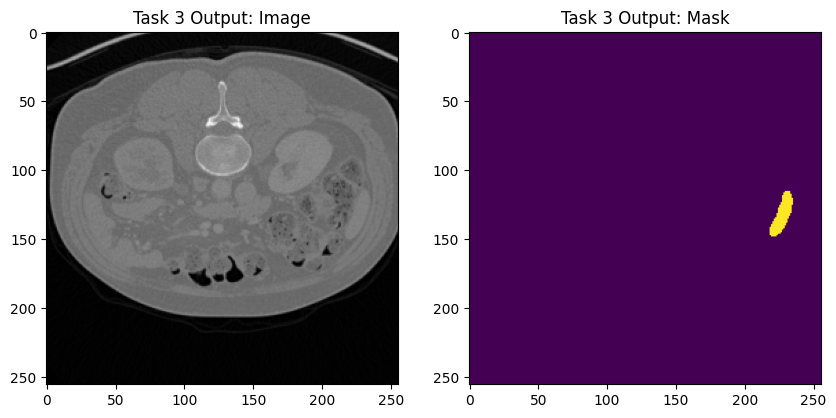

In [ ]:
import matplotlib.pyplot as plt
import torch

# 1. Grab one batch from your Data Loader (Task 3)
data_iter = iter(train_dataloader)
images, c_targets, oh_targets = next(data_iter)

# 2. Check the "Ingredients"
print("--- TASK 3 DIAGNOSIS ---")
print(f"1. Image Size: {images.shape}")
# PASS if: [32, 1, 256, 256] (or whatever batch size you set)
# FAIL if: [32, 3, ...] (Wrong channels) or [..., 64, 64] (Wrong size)

print(f"2. Pixel Range: Min={images.min():.2f}, Max={images.max():.2f}")
# PASS if: Min is approx 0.0 and Max is approx 1.0 (or close to it)
# FAIL if: Max is 255 (forgot to normalize) or Max is 4.0 (weird normalization)

print(f"3. Target Shape: {c_targets.shape}")
# PASS if: [32, 256, 256]

# 3. Visual Check
# We plot the image and the mask.
# If you see a clear grey X-ray and a clear white liver shape, TASK 3 IS PERFECT.
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(images[0, 0].cpu(), cmap='gray')
plt.title("Task 3 Output: Image")

plt.subplot(1, 2, 2)
plt.imshow(c_targets[0].cpu(), cmap='viridis')
plt.title("Task 3 Output: Mask")

plt.show()